#### Notebook modified from the original version by `Lukas Mosser` and `Navjot Kukreja`

In [1]:
!pip install pycm livelossplot
%pylab inline

# ACSE Module 8 - Practical - Morning Session 3:
----
# Training Deep Neural Networks - Cross-Validation

###Objectives of today's session:

- Design a fully connected feed forward neural network for MNIST
- Create a validation split and normalise it
- Perform a manual grid search on the momentum parameters
- Combine validation and training set once we have optimal momentum parameters and train the model again
- Run the test dataset and report accuracy
- Generate some of the plots we saw in the theory lectures to analyse performance

<br>

On Practical 2, we learned how to **train network parameters** using backpropagation. Today we will learn how to choose **hyperparameters**:

<img src="https://miro.medium.com/max/2140/1*pR6bSQXgC1Y_lYTeLDqVqg.png" alt="network" width="600"/>

#### A few imports before we get started

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

# Important concepts from Practicall session 2 revisited:

- **Recap 1**: `nn.Module` as a tool to define neural networks

We use the `nn.Module` class to define our network:

In [ ]:
# pseudo-code, don't try to run it!

class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        # define your layers and activations
        
    def forward(self, x):
        # define your network forward pass
        # return output of the network

- **Recap 2**: training loop structure

Training loop structure is always of the form (with variations, of course):

In [ ]:
# pseudo-code, don't try to run it!

model = DummyNetwork()                                    # get an instance of your network 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # define an optimiser (SGC, Adam, etc)
criterion = torch.nn.MSELoss()                            # define your loss function
model.train()                                             # tell the model we are going to train
    for X, y in data_loader:                              # iterate over epochs
        optimizer.zero_grad()                             # reset gradients
        output = model(X)          # forward propagtion through the model
        loss = criterion(y, output)    # compute loss
        loss.backward()            # backpropagate
        optimizer.step()           # update model parameters using the gradients

- **Recap 3**: `Dataset` and `Dataloader`

[`Datasets` and `Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) tutorial.

[`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) : an abstract class representing a dataset. <br>
[`Dataloader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader):  provides an iterable over the given dataset.

- **Additional reads**: Computational graphs (**not required**)

A good explanation of [computational graphs and autodifferentiation](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/)

---

## Task 1: Training a deep neural network on MNIST using Pytorch

In this exercise we will use cross-validation to estimate the hyperparameters of a deep-neural network trained on the MNIST dataset and create predictions on the MNIST datasets public test set.

## 1.1: Mounting the google drive for later storage

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

## 1.2: The MNIST Dataset - Hello World of Deep-Learning

In [6]:
# mnist_train = MNIST("./", download=True, train=True)
# mnist_test = MNIST("./", download=True, train=False)

## 1.3: Instantiate and create a ```StratifiedShuffleSplit``` generator using sklearn.
1. Create a ```sklearn.model_selection.StratifiedShuffleSplit``` object with 1-split and a test-size of 10%.
2. Get the training and validation indices from the shuffel-split

[`StratifiedShuffleSplit` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) (+ a trick to embed a website in notebooks for easy access while coding)

In [ ]:
%%html
<iframe src="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html" width="1200" height="300">
</iframe>

In [7]:
# shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.data, mnist_train.targets)
# indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
# print('indices type: ', type(indices))
# print('indices: ', indices)
# print('mnist_train type: ', type(mnist_train))
# print('mnist_train.data type: ', type(mnist_train.data))
# print('mnist_train.targets type: ', type(mnist_train.targets))
# print('mnist_train.targets size: ', mnist_train.targets.size())
# print('mnist_train targets: ', mnist_train.targets)
# print('pixel value of one mnist_train image: ', mnist_train.data[0][14][14].item())

## 1.4 `code along`: Split and standardise the data
The original mnist data is given in gray-scale values between 0 and 255.
You will need to write a normalisation method that takes in a ```torch.Tensor``` and performs normalisation.
The mean of MNIST is 0.1307 and it's standard deviation is 0.3081 (after division by 255). We could have computed these values using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) function in sklearn, but since they are provided here, use them directly.


In [ ]:
def apply_normalization(X):
  # normalize pixel values to the range 0 to 1. Pixel values are often unsigned integers in the range between 0 and 255.
  # mean of the pixel values in this data set is 0.1307
  # variance of the pixel values in this dataset is 0.3081
  return X

Use the indices computed above and normalise the data:

In [ ]:
X_train, y_train = apply_normalization(mnist_train.data[indices[0]].float()), mnist_train.targets[indices[0]] # index is 0 because that's how we defined the indices above
X_val, y_val = apply_normalization(mnist_train.data[indices[1]].float()), mnist_train.targets[indices[1]]     # index is 1 because that's how we defined the indices above
X_test, y_test =  apply_normalization(mnist_test.data.float()), mnist_test.targets                            # test dataset

## 1.5: Instantiate a ```torch.utils.data.TensorDataset``` for training, validation and test data

Remember from last session, we use `TensorDataset` to reduce the memory footprint and have a convenient way to access large datasets stored on disk.

In [ ]:
mnist_train = TensorDataset(X_train, y_train.long())    # PyTorch wants longs for categorical data
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

Let's visualise an example of the images and check whether the data is normalised properly (compute .mean() and .std() on the training set.)

0.00011968147737206891 1.000293493270874


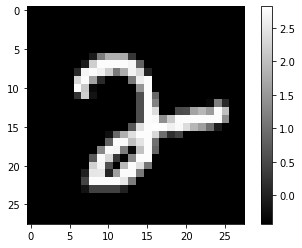

In [ ]:
plt.imshow(X_train[0], cmap=cm.gray)
plt.colorbar()
print(X_train.mean().item(), X_train.std().item())

And let's plot a few more:

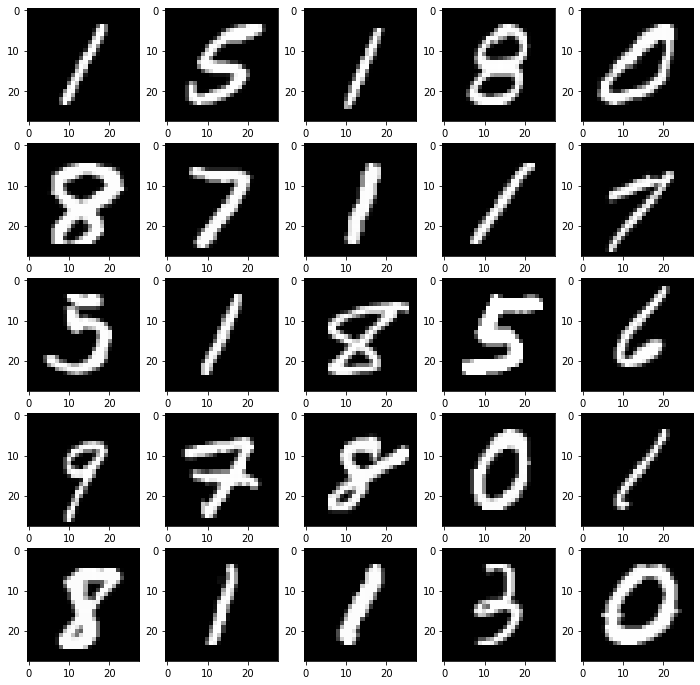

In [ ]:
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i], cmap=cm.gray)
plt.show()

## 1.6 `code along`: Create a SimpleNet as a ```nn.Module```
Create a simple feed-forward neural network with the following architecture:
- Input Layer: 28*28 neurons
- Hidden Layer: 25 neurons
- Output Layer: 10 neurons
- Hidden Layer Activation: ReLU
- Output Layer Activation: None

Which ones of these parameters are dictated by the nature of the dataset? <br>
What are these values we defined above?


In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # use nn.Linear and nn.Relu to define your layers and activations
        
        
    def forward(self, x):
        # code your forward pass using the layers and activations above

        return z2   # return z2 (not a2, we will see this later)

[`nn.Linear` documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) <br>
[`nn.ReLu` documentation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

Let's check the input, hidden, and output sizes.

What happens if we comment out parts or of all the forward function?

In [9]:
set_seed(42) # what does the setting the seed does here?
model = SimpleNet()
X_ = X_train[0].view(-1,28*28)
y_ = model(X_)
print(y_.shape,y_.max())#.item())

The `torch.view` function is similar to `torch.reshape` in PyTorch. But since `torch.reshape` behaves a bit erratically in terms of copying or providing a view of the tensor, we will always use `torch.view`. You can find a good explanation of the differences [here](https://stackoverflow.com/questions/49643225/whats-the-difference-between-reshape-and-view-in-pytorch)

## 1.7: Sanity checks on our SimpleNet


In [8]:
set_seed(42) # what does the setting the seed does here?
model = SimpleNet().to(device) ## .to(device) loads the model on the device, i.e GPUs in this example
criterion = nn.CrossEntropyLoss() # change to NLLLoss if you want to keep the softmax in the module (network)

X_ = X_train[0].view(-1, 28*28).to(device)  ## get 1 sample only. Also .view(-1,28*28) reshapes the tensor to get it ready for the first fully connected layer. 
## the dimension of -1 implies that the actual value for this dimension will be inferred so that the number of elements in the view matches the original number of elements.

y_ = torch.zeros((1)).to(device).long().to(device) # loads the tensor to the current device in use, i.e the GPUs
a2 = model(X_) ## a2 = z2 in this case since SimpleNet is returning z2
loss = criterion(a2, y_) ## the loss criterion CrossEntropyLoss(), combines nn.LogSoftMax and nn.NLLLoss so it is essentially computing the loss between the non_linear transform of z2 and the label y_
y_pred = F.log_softmax(a2, dim=1).max(1)[1] ## gives the predicted value as the maximum probability value index based on the log_softmax operation on a2

print(F.log_softmax(a2, dim=1))
print('prediction:                                 ', y_pred.item())
print('true value (we force it to be zero above!): ', y_.item())

Note that we have left the last activation out of our network. This is because PyTorch's [`CrossEntropyLoos`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) already includes a [`LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) operation.

## 1.8 `code along`: Create simple train function

The function should perform the following tasks:
1. Set the model into training mode
2. Iterate over all the mini-batches
3. Send the batches to the GPU / CPU
4. Zero all the gradients
5. Perform the forward-pass
6. Compute the loss
7. Perform the backward-pass
8. Keep a running measure of training loss and accuracy
9. Perform a step of gradient-descent
10. Once done with all batches, return average training loss and accuracy

In [ ]:
def train(model, optimizer, criterion, data_loader):
    # set the model in training mode so the parameters(weights)to be optimised will be updated
    train_loss, train_accuracy = 0, 0 # initialise loss and accuracy to 0 for training
    for X, y in data_loader:              # iterate over the mini-batches defined in the data loader
        X, y = X.to(device), y.to(device) # send data to the device (GPU in our case)
        # resetting optimiser info
        # forward pass
        # compute loss
        # backpropagation to calculate the gradients
        train_loss += loss*X.size(0)  # add it up for different mini-batches and undo loss normalisation
        # get y_pred (predictions)
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy
        # perform a step of gradient descent
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset

## 1.9 `code along`: Create simple validate function

The function should perform the following tasks:
1. Set the model into evaluation mode
2. Iterate over all the mini-batches
3. Send the batches to the GPU / CPU
5. Perform the forward-pass
6. Compute the loss
8. Keep a running measure of validation loss and accuracy
10. Once done with all batches, return average validation loss and accuracy

In [ ]:
def validate(model, criterion, data_loader):      # does not need optimiser
    # set model to evaluation mode so no dropout or any other funny stuff happens here
    validation_loss, validation_accuracy = 0., 0. # initialise loss and accuracy to 0 for training
    for X, y in data_loader:                      # iterate over the mini-batches defined in the data loader
        with torch.no_grad():                     # deactivates autograd engine
            X, y = X.to(device), y.to(device)     # send data to the device (GPU in our case)
            # forward pass
            # evaluate loss
            validation_loss += loss*X.size(0)     # add it up for different mini-batches and undo loss normalisation
            # get y_pred (predictions)
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # compute accuracy
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset

 ## 1.10: Set the hyperparameters of your model
- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training, but affects validation times): 1000
- Shuffle the training set every epoch: Yes

In [ ]:
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 64
test_batch_size = 1000
n_epochs = 30

## 1.11 `code along`: Instantiate our model, optimizer and loss function
1. Set the random number generator seed using ```set_seed``` to make everything reproducible.
2. get an instance of the model and send it to the GPU with `.to(device)`
3. use an SGD optimiser with the lr and momentum defined above
4. use a sensible loss criterion for our multi-class classification problem

In [ ]:
set_seed(seed)
model =     # instantiate model and send it to the GPU
optimizer = # instantiate the optimizer
criterion = # define the loss

## 1.12: Create dataloaders for the training, validation and test data

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data.
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

Do you know what `shuffle` do? Why do we use it here?

If num_workers=2 for example, 2 other workers will put data into the RAM instead of the main process. Good discussion about how to choose it [here](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/5) (**not required**)

## 1.13: Perform the training of the network and validation
Here we provide you with a method to visualize both training and validation loss while training your networks using [livelossplot](https://github.com/stared/livelossplot).

As the repo says: *Don't train deep learning models blindfolded! Be impatient and look at each epoch of your training!*

With this method we will be able to generate the plots Olivier shoed in his slides:

<img src="https://raw.githubusercontent.com/acse-2020/ACSE-8/main/implementation/practical_3/Figs/UsingValidationDuringTraining.png?token=ABNZJPZVFB6UI7ZOUPR5BB3ATFFSW" width=600/>

In [10]:
set_seed(seed)
liveloss = PlotLosses()    # plots evolution of loss and accuracy
for epoch in range(30):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())

It seems the model isn't doing very well. Let's optimise a hyperparameter to see if we can do any better.

## 1.14 `code along`: Running a grid-search
We will run a grid search over the momentum value using the following: `momentum = [0.1, 0.5, 0.9]`
to figure out the 'best' value of momentum.

In [11]:
def train_model(momentum):          # define function train_momentum which accepts one argument (momentum)
  # set seed
  # instantiate model and send it to the GPU
  # define an optimiser
  # define the loss function
  
  # train_loader
  # validation_loader
  # test_loader
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['log loss'] = train_loss.item()
      logs['accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_log loss'] = validation_loss.item()
      logs['val_accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return True

In [12]:
# train model with momentum 0.1

In [13]:
# train model with momentum 0.5

In [14]:
# train model with momentum 0.9

In [ ]:
best_momentum = # ??

## 1.15: Implement an evaluate method
This method performs the same as validate but doesn't report losses, but simply returns all predictions on a given dataset (training, validation, test-set)

In [15]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 28*28))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
    
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0) ## concatenate the labels of each batch into a single list

y_pred, y_gt = evaluate(model, validation_loader)
print(y_pred, y_gt)

## 1.17: Plotting a confusion matrix

We can use a confusion matrix to diagnose problems in our models.
What numbers are missclassified more often?

(To generate the confusion matrix we use the [PyCM library](https://www.pycm.ir/doc/index.html))

In [16]:
cm = ConfusionMatrix(actual_vector=y_gt, predict_vector=y_pred) ## Create the confusion matrix from Data. ConfusionMatrix is a class derived from the pycm library
print(cm)
## the rows of the confusion matrix give the number of the instances in the actual class that were wrongly predicted.

In [17]:
import seaborn as sns

def to_raw_matrix(cm):
    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    return plt_cm

rcm = to_raw_matrix(cm) #store the confusion matrix values

sns.heatmap(rcm, cmap="Blues", vmin=0, vmax=25)

## 1.18: Given that you estimated your hyperparameters, train your model on the full dataset and evaluate on the test set

In [18]:
mnist_train = MNIST("./", download=True, train=True)

X_train, y_train = apply_normalization(mnist_train.train_data.float()), mnist_train.train_labels
mnist_train = TensorDataset(X_train, y_train)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)  # now we define 4 workers to load the mini-batches

set_seed(seed)
model = SimpleNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=best_momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['log loss'] = train_loss.item()
    logs['accuracy'] = train_accuracy.item()

    # test_loss, test_accuracy = validate(model, criterion, test_loader)
    # logs['val_' + 'log loss'] = test_loss.item()
    # logs['val_' + 'accuracy'] = test_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(model, criterion, test_loader)    # first time we use the test dataset!
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

## 2.1: Storing and loading models - Pytorch State-Dicts

Pytorch stores all the parameters of models and optimizers, their weights and biases in an easy to read dictionary called a "state-dict".
When we store models and optimizers, we store the state-dict.  
Together with the model definition we can then restore the model to it's state when we stored it to disk.
Let's look at the contents of the state-dict of both our optimizer and our model:

In [19]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

## print(model) can also be used to print-out the layers of the model sequentially. However, this does not produce a visualization.

## 2.2: Storing models to disk
From colab (and locally) we can store models to disk using ```torch.save``` and passing both a models state_dict() and a path where to store it.

In [ ]:
#!mkdir '/content/gdrive/My Drive/models'  ## create the director for storing the model

model_save_name = 'simplenet_mnist_classifier.pt' ## .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)

optimiser_save_name = 'simplenet_mnist_classifier_optimiser.pt' ## .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{optimiser_save_name}" 
torch.save(model.state_dict(), path)

## 2.3: Loading models from checkpoints
Finally, we can restore models from the saved ```state_dict```'s and do a number of things such as:
1. Continue training (given we stored the optimizer as well)
2. Make predictions from our model
3. Perform inspections of our model
4. Use our model in ensembles 
5. ...

By default a loaded model is put into ```.train()``` mode. So be careful when using networks that behave different depending on training and test time e.g. dropout regularized networks or batch-normalized networks.

In [20]:
model = SimpleNet().to(device) ## creates an instance of the model
model.load_state_dict(torch.load(path)) ## loads the parameters of the model in path. state_dict is a dictionary object that maps each layer in the model to its trainable parameters (weights and biases).
model.eval()

test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")

We had this before: Avg. Test Loss: 0.112  Avg. Test Accuracy: 0.967

Our model performs exactly the same as before storing it to disk.

[Here](https://pytorch.org/tutorials/beginner/saving_loading_models.html) you can find a document with a more in-depth description on how to save and load PyTorch models

---

#Summary of the day:

- First network designed to work on MNIST.
- `StratifiedShuffleSplit` class generates a validation set.
- Hyperparameter optimisation (momentum in today's lecture, but the same concept can be extended to any hyperparameter) with a manual grid search.
- Improve performance by retraining full dataset (training + validation) with optimal hyperparameter derived from cross-validation.
- Confusion matrix as a tool to better understand the limitations of our models.
- Save and load Pytorch models.